状态价值函数:

V(state) = 所有动作求和 -> 概率(action) * Q(state,action)

对这个式子做变形得到:

V(state) = 所有动作求和 -> 现概率(action) * \[旧概率(action) / 现概率(action)\] * Q(state,action)

初始时可以认为现概率和旧概率相等,但随着模型的更新,现概率会变化.

式子中的Q(state,action)可以用蒙特卡洛法估计.

按照策略梯度的理论,状态价值取决于动作的质量,所以只要最大化V函数,就可以得到最好的动作策略.

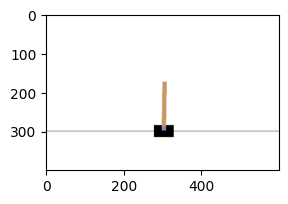

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch

#定义模型
model_action = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax(dim=1),
)

model_value = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_action(torch.randn(2, 4)), model_value(torch.randn(2, 4))

(tensor([[0.5028, 0.4972],
         [0.5123, 0.4877]], grad_fn=<SoftmaxBackward0>),
 tensor([[-0.0145],
         [ 0.0464]], grad_fn=<AddmmBackward0>))

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []
    next_state = []
    over = []

    s = env.reset()
    o = False
    while not o:
        #根据概率采样
        prob = model_action(torch.FloatTensor(s).reshape(1, 4))[0].tolist()
        a = random.choices(range(2), weights=prob, k=1)[0]

        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)
        next_state.append(ns)
        over.append(o)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state).reshape(-1, 4)
    action = torch.LongTensor(action).reshape(-1, 1)
    reward = torch.FloatTensor(reward).reshape(-1, 1)
    next_state = torch.FloatTensor(next_state).reshape(-1, 4)
    over = torch.LongTensor(over).reshape(-1, 1)

    return state, action, reward, next_state, over, reward.sum().item()


state, action, reward, next_state, over, reward_sum = play()

reward_sum

/tmp/ipykernel_7761/1112667714.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = torch.FloatTensor(state).reshape(-1, 4)


-979.0

In [4]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=1e-3)
optimizer_value = torch.optim.Adam(model_value.parameters(), lr=1e-2)


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)

In [5]:
def train_value(state, reward, next_state, over):
    requires_grad(model_action, False)
    requires_grad(model_value, True)

    #计算target
    with torch.no_grad():
        target = model_value(next_state)
    target = target * 0.98 * (1 - over) + reward

    #每批数据反复训练10次
    for _ in range(10):
        #计算value
        value = model_value(state)

        loss = torch.nn.functional.mse_loss(value, target)
        loss.backward()
        optimizer_value.step()
        optimizer_value.zero_grad()

    #减去value相当于去基线
    return (target - value).detach()


value = train_value(state, reward, next_state, over)

value.shape

torch.Size([22, 1])

In [6]:
def train_action(state, action, value):
    requires_grad(model_action, True)
    requires_grad(model_value, False)

    #计算优势函数
    delta = []
    for i in range(len(value)):
        s = 0
        for j in range(i, len(value)):
            s += value[j] * (0.98 * 0.95)**(j - i)
        delta.append(s)
    delta = torch.FloatTensor(delta).reshape(-1, 1)

    #更新前的动作概率
    with torch.no_grad():
        prob_old = model_action(state).gather(dim=1, index=action)

    #每批数据反复训练10次
    for _ in range(10):
        #更新后的动作概率
        prob_new = model_action(state).gather(dim=1, index=action)

        #求出概率的变化
        ratio = prob_new / prob_old

        #计算截断的和不截断的两份loss,取其中小的
        surr1 = ratio * delta
        surr2 = ratio.clamp(0.8, 1.2) * delta

        loss = -torch.min(surr1, surr2).mean()

        #更新参数
        loss.backward()
        optimizer_action.step()
        optimizer_action.zero_grad()

    return loss.item()


train_action(state, action, value)

481.4684753417969

In [7]:
def train():
    model_action.train()
    model_value.train()

    #训练N局
    for epoch in range(1000):
        #一个epoch最少玩N步
        steps = 0
        while steps < 200:
            state, action, reward, next_state, over, _ = play()
            steps += len(state)

            #训练两个模型
            delta = train_value(state, reward, next_state, over)
            loss = train_action(state, action, delta)

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss, test_result)


train()

0 57.404075622558594 -978.6
100 -18.518997192382812 200.0
200 0.9326910972595215 200.0
300 -0.06682347506284714 200.0
400 -0.040946170687675476 200.0
500 -0.3048292398452759 200.0
600 -0.3876965045928955 200.0
700 2.3514397144317627 200.0
800 1.754111886024475 200.0
900 25.258014678955078 200.0


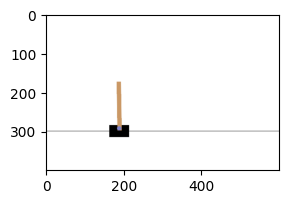

200.0

In [8]:
play(True)[-1]